In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [22]:
# Load datasets

train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')

In [23]:
# Drop unnamed columns if present

train_df.drop(columns=[col for col in train_df.columns if 'Unnamed' in col], inplace=True)
test_df.drop(columns=[col for col in test_df.columns if 'Unnamed' in col], inplace=True)

# Add source column to distinguish train and test data

train_df['source'] = 'train'
test_df['source'] = 'test'

# Combine train and test data for uniform processing

combined = pd.concat([train_df, test_df], axis=0)

In [24]:
# Feature Engineering: Extract date/time features if the column exists

if 'trans_date_trans_time' in combined.columns:
    combined['trans_date_trans_time'] = pd.to_datetime(combined['trans_date_trans_time'])
    combined['hour'] = combined['trans_date_trans_time'].dt.hour
    combined['day'] = combined['trans_date_trans_time'].dt.day
    combined['weekday'] = combined['trans_date_trans_time'].dt.weekday

# Frequency encoding for 'merchant' and 'category'

for col in ['merchant', 'category']:
    if col in combined.columns:
        freq = combined[col].value_counts(normalize=True)
        combined[f'{col}_freq'] = combined[col].map(freq)

In [25]:
# Drop unnecessary or non-numeric columns (only if they exist)

drop_cols = ['trans_num', 'trans_date_trans_time', 'first', 'last', 'street', 'city', 'job', 'merchant', 'dob']
combined.drop(columns=[col for col in drop_cols if col in combined.columns], inplace=True)

# Encode gender: M -> 0, F -> 1

if 'gender' in combined.columns:
    combined['gender'] = combined['gender'].map({'M': 0, 'F': 1})

# One-hot encode 'state' and 'category' if present

for col in ['state', 'category']:
    if col in combined.columns:
        combined = pd.get_dummies(combined, columns=[col], drop_first=True)

In [26]:
# Split combined data back into train and test datasets

train_df = combined[combined['source'] == 'train'].drop('source', axis=1)
test_df = combined[combined['source'] == 'test'].drop('source', axis=1)

In [27]:
# Features (X) and target labels (y) for training and testing

X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [28]:
# Scale features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=[np.number]))

In [29]:
# Models dictionary for evaluation

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=8, min_samples_split=50),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10)
}

results = {}

# Train, predict, and evaluate each model

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    
    # Store model performance metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1 Score': f1_score(y_test, preds),
        'ROC AUC': roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    }
    
    # Print classification report and confusion matrix
    print(f"\n{name} Report:\n")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


Logistic Regression Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

Confusion Matrix:
 [[553226    348]
 [  2145      0]]

Decision Tree Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.86      0.68      0.76      2145

    accuracy                           1.00    555719
   macro avg       0.93      0.84      0.88    555719
weighted avg       1.00      1.00      1.00    555719

Confusion Matrix:
 [[553339    235]
 [   693   1452]]

Random Forest Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.93      0.53      0.67      21

In [30]:
# Predictions for test dataset

predictions = models['Random Forest'].predict(X_test_scaled)
probabilities = models['Random Forest'].predict_proba(X_test_scaled)[:, 1]

In [31]:
# Prepare results to print

test_results = test_df.copy()
test_results['predicted_is_fraud'] = predictions
test_results['fraud_probability'] = probabilities

In [32]:
# Print first 10 predictions with fraud probabilities

print("\nFirst 10 predictions with fraud probabilities:")
display_cols = [col for col in ['amt', 'predicted_is_fraud', 'fraud_probability'] if col in test_results.columns]
print(test_results[display_cols].head(10))


First 10 predictions with fraud probabilities:
      amt  predicted_is_fraud  fraud_probability
0    2.86                   0           0.000771
1   29.84                   0           0.001879
2   41.28                   0           0.001133
3   60.05                   0           0.001015
4    3.19                   0           0.001918
5   19.55                   0           0.002138
6  133.93                   0           0.001030
7   10.37                   0           0.002309
8    4.37                   0           0.000529
9   66.54                   0           0.001089


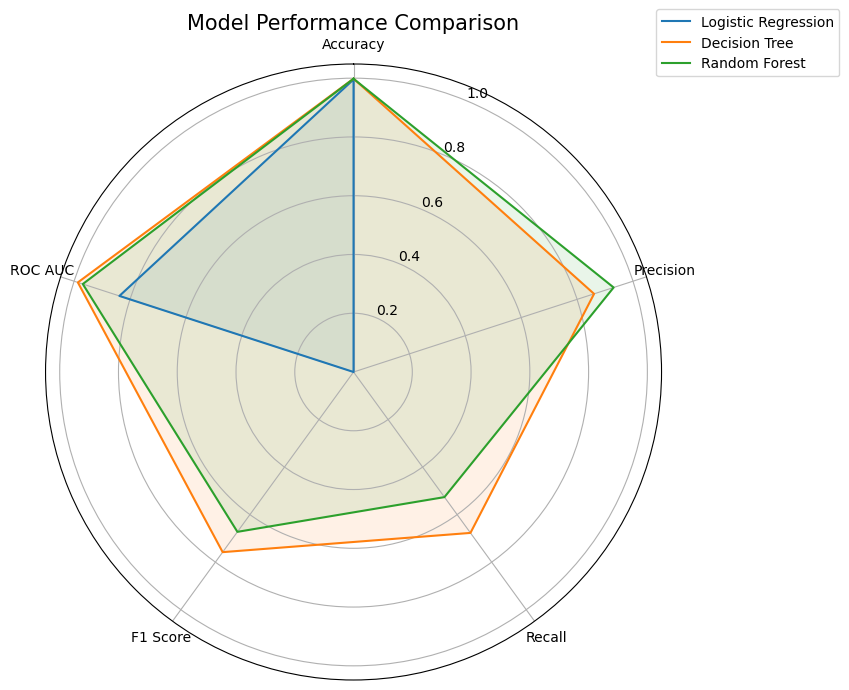

In [33]:
# Radar plot for performance comparison

def plot_radar(results_dict):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    for name, scores in results_dict.items():
        values = [scores[m] for m in metrics]
        values += values[:1]  # Close the circle
        ax.plot(angles, values, label=name)
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title("Model Performance Comparison", size=15)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

plot_radar(results)